# TP Coding a GAN in Pytorch

## Objective:

The goal of this TP is to explore GANs applied to the mnist (and possibly cifar10) datasets.

We will start with the mnist dataset.

### Your task:
You need to add the missing parts in the code (parts between # --- START CODE HERE and # --- END CODE HERE or # FILL IN CODE)

First of all, let's load some packages

In [1]:

import matplotlib.pyplot as plt
import sys
import numpy as np
import pickle
import copy
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

def pytorch_to_numpy(x):
  return x.detach().numpy()


# Decide which device we want to run on
if (torch.cuda.is_available()):
  device = torch.device("cuda:0")
else:
  device = "cpu"


## 1/ Loading the data

We define a function to load the mnist or cifar10 datasets. Note, we normalise the data between -1 and 1 here (this is often the case for GANs).

In [2]:

# create a random seed for reproducible results
random_seed = 1
torch.manual_seed(random_seed)

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])

# MNIST Dataset
mnist_trainset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
mnist_testset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

#create data loader with smaller dataset size
max_mnist_size = 1000
mnist_trainset_reduced = torch.utils.data.random_split(mnist_trainset, [max_mnist_size, len(mnist_trainset)-max_mnist_size])[0] 
mnist_train_loader = torch.utils.data.DataLoader(mnist_trainset_reduced, batch_size=64, shuffle=True)

# download test dataset
max_mnist_size = 512
mnist_testset_reduced = torch.utils.data.random_split(mnist_testset, [max_mnist_size, len(mnist_testset)-max_mnist_size])[0] 
mnist_test_loader = torch.utils.data.DataLoader(mnist_testset_reduced, batch_size=64, shuffle=True)



In [3]:
n_rows = mnist_trainset_reduced.dataset.train_data.shape[1]
n_cols = mnist_trainset_reduced.dataset.train_data.shape[2]
n_channels = 1
n_pixels = n_rows*n_cols

img_shape = (n_rows, n_cols, n_channels)

c:\Users\rocha\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


## 2/ GAN parameters

In [4]:

## GAN parameters
z_dim = 10
batch_size = 64
## parameters for training
n_epochs = 400
n_iters_inner=1	#number of internal loops
sample_interval=100
# Learning rate for optimizers
lr = 0.0002
beta_1 = 0.5

# hidden dimensions : careful, the order here is with respect to the generator, and the discriminator is in the opposite order
h_dim_1 = 256
h_dim_2 = 512

## 3/ Model architecture

Now, we define the model architecture.

For the first dataset, mnist, we are going to use fully connected layers. Implement the following architecture, for the generator and the discriminator :

Generator :
- Dense layer, to size 256
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, to size 512
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, output size 784
- Tanh activation
- Reshape to size $28 \times 28 \times 1$

Discriminator :
- Flatten
- Dense layer, to size 512
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, output size 256
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, output size 1
- Sigmoid activation

In [5]:
# Generator Code

class Generator(nn.Module):
  def __init__(self, z_dim, h_dim_1, h_dim_2, n_rows,n_cols,n_channels):
    super(Generator, self).__init__()
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.n_channels = n_channels
    self.n_pixels = (self.n_rows)*(self.n_cols)
    self.h_dim_1 = h_dim_1
    self.h_dim_2 = h_dim_2
    self.z_dim = z_dim

    self.fc1 = nn.Linear(self.z_dim, self.h_dim_1) # FILL IN HERE
    self.fc2 = nn.Linear(self.h_dim_1, self.h_dim_2) # FILL IN HERE 
    self.fc3 = nn.Linear(self.h_dim_2, self.n_pixels) # FILL IN HERE 
  def forward(self, z):
    y = torch.nn.LeakyReLU(0.2)(self.fc1(z)) # FILL IN HERE
    y = torch.nn.LeakyReLU(0.2)(self.fc2(y)) # FILL IN HERE 
    y = torch.tanh(self.fc3(y)) 
    y = y.view(y.shape[0], self.n_channels, self.n_rows, self.n_cols) 
    return(y)


In [6]:

class Discriminator(nn.Module):
  def __init__(self, h_dim_2, h_dim_1, z_dim, n_rows,n_cols,n_channels):
    super(Discriminator, self).__init__()

    self.n_rows = n_rows
    self.n_cols = n_cols
    self.n_channels = n_channels
    self.n_pixels = (self.n_rows)*(self.n_cols)
    self.h_dim_1 = h_dim_1
    self.h_dim_2 = h_dim_2
    self.z_dim = z_dim

    self.fc1 = nn.Linear( self.n_pixels, h_dim_2)
    self.fc2 = nn.Linear(h_dim_2, h_dim_1)
    self.fc3 = nn.Linear(h_dim_1, 1)

  def forward(self, x):
    y = torch.nn.Flatten()(x)
    y = torch.nn.LeakyReLU(0.2)(self.fc1(y))
    y = torch.nn.LeakyReLU(0.2)(self.fc2(y))
    y = torch.sigmoid(self.fc3(y))
    return y




Create generator and discriminator 

In [7]:
gen_model = Generator(z_dim, h_dim_1, h_dim_2, n_rows,n_cols,n_channels)  # FILL IN HERE
# Print the model
print(gen_model)

disc_model = Discriminator(h_dim_2, h_dim_1, z_dim, n_rows,n_cols,n_channels) # FILL IN HERE
# Print the model
print(disc_model)

Generator(
  (fc1): Linear(in_features=10, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=784, bias=True)
)
Discriminator(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)


## 4/ Loss function


The GAN loss function is the following :
\begin{equation}
	\min_{G} \max_{D} \mathbb{E}_{x \in p_{data}} \left[ \log D(x)\right] +
	\mathbb{E}_{z \in p_{z}}\left[ \log \left( 1 - D(G(z)) \right)\right],
\end{equation}
where $G$ is the generator, $D$ is the discriminator, $z$ is the latent code, which follows a normal distribution.

You should notice that this is extremely similar to the binary cross-entropy function. Therefore, there is an intelligent way to train the discriminator : we give it first a batch of real images, and label them as real, and secondly we give a batch of fake images and label them as fake. Therefore, the discriminator training itself is done in two sequential steps (first true, then fake). If the labels are correctly chosen (further on, during training), you can (and __should__) use the binary cross-entropy function.

The generator loss, however, must be specified as :
- $mean(\log(1-D(G(z))))$

You can use the ```torch.mean``` function for this purpose.


The training is carried out sequentially : first we execute a few training steps on the discriminator, and then one on the generator. Therefore, we use two loops : one to train the discriminator (the internal loop) and one to train the generator (external loop, ie. the number of epochs). The GAN training algorithm is as follows :

- For $i=0$ to $n-1$
  - For $j=0$ to $m-1$
    - $x \leftarrow$ random batch of data
    - $z \leftarrow$ random batch of latent codes
    - Train discriminator on real images $x$
    - Train discriminator on fake images $G(z)$
  - $z \leftarrow$ random batch of latent codes
  - Train discriminator on fake images $G(z)$



In [8]:

# Setup Adam optimizers for both G and D
optimizer_disc = optim.Adam(disc_model.parameters(), lr=lr, betas=(beta_1, 0.999))
optimizer_gen = optim.Adam(gen_model.parameters(), lr=lr, betas=(beta_1, 0.999))

# criterion used for the discriminator loss
bce_criterion = nn.BCELoss()

# criterion used for the generator loss
def loss_fn_gen(d_gen_data):
  loss_gen = -torch.mean(torch.log(d_gen_data)) 
  return loss_gen

	

### Sampling function

We now create a function to sample several images during training (to follow the convergence of the network)

In [9]:

def sample_images(generator,z_dim, rand_seed=30):
  #np.random.seed(rand_seed)
  r, c = 5, 5
  z_random = torch.randn(r * c, 1, z_dim, dtype=torch.float, device=device) #np.random.normal(0, 1, (r * c, z_dim))
  
  gen_imgs = np.transpose( generator(z_random).cpu().detach().numpy() , (0,2,3,1))

  # Rescale images 0 - 1
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
    for j in range(c):
      #black and white images
      if(gen_imgs.shape[3] == 1):
        axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
      elif(gen_imgs.shape[3] == 3):   #colour images
        gen_imgs_temp = gen_imgs.copy()
        gen_imgs_temp = 255.*np.clip(gen_imgs_temp,0.0,1.0) 
        axs[i,j].imshow(gen_imgs_temp[cnt, :,:,:].astype(np.uint8))
      else:
        print('Error, unsupported channel size. Dude, I don''t know what you want me to do.\
            I can''t handle this data. You''ve made me very sad ...')
      axs[i,j].axis('off')
      cnt += 1
  plt.show()

## 5/ Training

We are now ready to train the network. Here is the training algorithm again :

- For $i=0$ to $n-1$
  - For $j=0$ to $m-1$
    - $x \leftarrow$ random batch of data
    - $z \leftarrow$ random batch of latent codes
    - Train discriminator on real images $x$
    - Train discriminator on fake images $G(z)$
  - $z \leftarrow$ random batch of latent codes
  - Train discriminator on fake images $G(z)$

You can use ```np.random.normal``` to create a batch of random latent codes, and ```np.random.randint``` to create a batch of random images.

You can then train the discriminator and the generator using the ```train_on_batch``` function.

We do not worry here about looping over the whole database : just create a random batch at each iteration.

Starting Training


[0/400][0/16] 	Loss_D: 1.4496	Loss_G: 0.7195	D(x): 0.4578	D(G(z)): 0.4873


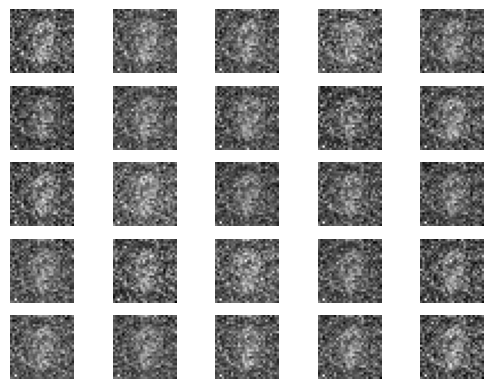

[1/400][0/16] 	Loss_D: 0.9775	Loss_G: 0.6350	D(x): 0.8660	D(G(z)): 0.5651
[2/400][0/16] 	Loss_D: 1.1898	Loss_G: 0.6280	D(x): 0.7424	D(G(z)): 0.5889
[3/400][0/16] 	Loss_D: 1.1822	Loss_G: 0.7875	D(x): 0.7047	D(G(z)): 0.5637
[4/400][0/16] 	Loss_D: 1.1665	Loss_G: 0.9104	D(x): 0.6894	D(G(z)): 0.5466
[5/400][0/16] 	Loss_D: 1.2774	Loss_G: 0.9280	D(x): 0.6892	D(G(z)): 0.5910
[6/400][0/16] 	Loss_D: 1.0688	Loss_G: 1.2253	D(x): 0.7255	D(G(z)): 0.5228
[7/400][0/16] 	Loss_D: 1.0691	Loss_G: 1.5635	D(x): 0.7875	D(G(z)): 0.5575
[8/400][0/16] 	Loss_D: 0.6853	Loss_G: 1.8726	D(x): 0.8285	D(G(z)): 0.3838
[9/400][0/16] 	Loss_D: 0.5812	Loss_G: 1.6574	D(x): 0.8660	D(G(z)): 0.3517
[10/400][0/16] 	Loss_D: 1.0408	Loss_G: 1.2346	D(x): 0.8299	D(G(z)): 0.5714
[11/400][0/16] 	Loss_D: 1.4434	Loss_G: 0.8462	D(x): 0.7453	D(G(z)): 0.6769
[12/400][0/16] 	Loss_D: 1.3513	Loss_G: 0.7569	D(x): 0.6193	D(G(z)): 0.5754
[13/400][0/16] 	Loss_D: 1.2400	Loss_G: 0.8014	D(x): 0.6309	D(G(z)): 0.5367
[14/400][0/16] 	Loss_D: 1.1265	Los

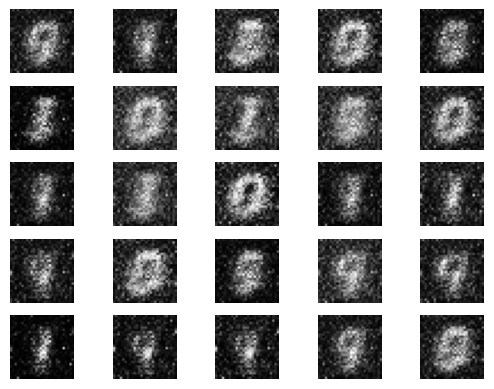

[26/400][0/16] 	Loss_D: 1.0766	Loss_G: 0.9726	D(x): 0.7795	D(G(z)): 0.5521
[27/400][0/16] 	Loss_D: 1.0659	Loss_G: 1.1458	D(x): 0.6726	D(G(z)): 0.4648
[28/400][0/16] 	Loss_D: 1.2522	Loss_G: 1.8136	D(x): 0.8373	D(G(z)): 0.6376
[29/400][0/16] 	Loss_D: 1.3208	Loss_G: 0.6308	D(x): 0.3765	D(G(z)): 0.2447
[30/400][0/16] 	Loss_D: 1.4346	Loss_G: 2.0956	D(x): 0.8811	D(G(z)): 0.7183
[31/400][0/16] 	Loss_D: 1.0666	Loss_G: 0.7615	D(x): 0.4933	D(G(z)): 0.2553
[32/400][0/16] 	Loss_D: 0.9164	Loss_G: 1.1003	D(x): 0.6206	D(G(z)): 0.3337
[33/400][0/16] 	Loss_D: 0.8326	Loss_G: 1.0178	D(x): 0.6070	D(G(z)): 0.2470
[34/400][0/16] 	Loss_D: 0.8800	Loss_G: 1.0463	D(x): 0.5350	D(G(z)): 0.1552
[35/400][0/16] 	Loss_D: 0.8054	Loss_G: 1.6070	D(x): 0.7287	D(G(z)): 0.3634
[36/400][0/16] 	Loss_D: 0.8641	Loss_G: 1.3978	D(x): 0.7055	D(G(z)): 0.3728
[37/400][0/16] 	Loss_D: 1.2055	Loss_G: 2.3659	D(x): 0.9040	D(G(z)): 0.6407
[38/400][0/16] 	Loss_D: 0.9734	Loss_G: 1.0087	D(x): 0.5982	D(G(z)): 0.2974
[39/400][0/16] 	Loss_D: 0

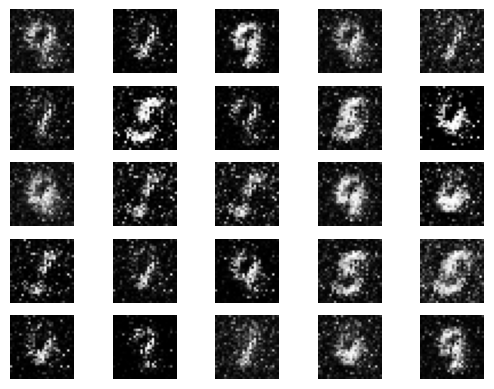

[51/400][0/16] 	Loss_D: 0.7151	Loss_G: 2.1758	D(x): 0.8304	D(G(z)): 0.3973
[52/400][0/16] 	Loss_D: 0.8353	Loss_G: 0.9014	D(x): 0.5935	D(G(z)): 0.1947
[53/400][0/16] 	Loss_D: 0.6948	Loss_G: 2.4501	D(x): 0.8050	D(G(z)): 0.3471
[54/400][0/16] 	Loss_D: 0.7584	Loss_G: 2.0320	D(x): 0.7591	D(G(z)): 0.3519
[55/400][0/16] 	Loss_D: 0.7419	Loss_G: 1.6842	D(x): 0.6842	D(G(z)): 0.2591
[56/400][0/16] 	Loss_D: 0.8329	Loss_G: 1.3784	D(x): 0.6512	D(G(z)): 0.2555
[57/400][0/16] 	Loss_D: 0.7870	Loss_G: 1.9245	D(x): 0.7514	D(G(z)): 0.3413
[58/400][0/16] 	Loss_D: 0.8927	Loss_G: 1.9131	D(x): 0.7561	D(G(z)): 0.4036
[59/400][0/16] 	Loss_D: 1.0966	Loss_G: 1.0878	D(x): 0.5362	D(G(z)): 0.3011
[60/400][0/16] 	Loss_D: 1.1245	Loss_G: 2.9117	D(x): 0.9055	D(G(z)): 0.6069
[61/400][0/16] 	Loss_D: 0.8424	Loss_G: 1.4809	D(x): 0.6757	D(G(z)): 0.3202
[62/400][0/16] 	Loss_D: 0.8186	Loss_G: 1.4497	D(x): 0.6661	D(G(z)): 0.2932
[63/400][0/16] 	Loss_D: 1.3519	Loss_G: 0.5908	D(x): 0.3390	D(G(z)): 0.1044
[64/400][0/16] 	Loss_D: 0

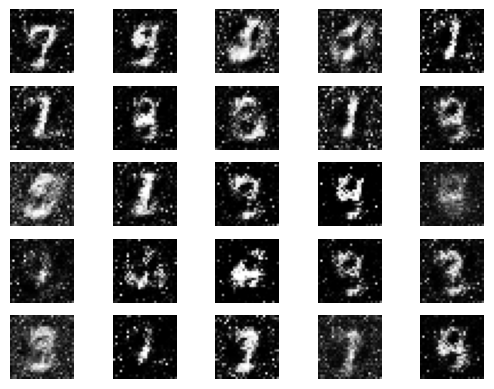

[76/400][0/16] 	Loss_D: 1.2651	Loss_G: 0.7323	D(x): 0.3885	D(G(z)): 0.0919
[77/400][0/16] 	Loss_D: 0.8096	Loss_G: 1.4523	D(x): 0.7504	D(G(z)): 0.3646
[78/400][0/16] 	Loss_D: 0.6916	Loss_G: 1.6281	D(x): 0.7602	D(G(z)): 0.2983
[79/400][0/16] 	Loss_D: 0.6732	Loss_G: 1.2954	D(x): 0.6957	D(G(z)): 0.2225
[80/400][0/16] 	Loss_D: 0.9034	Loss_G: 0.8624	D(x): 0.5180	D(G(z)): 0.1363
[81/400][0/16] 	Loss_D: 0.7961	Loss_G: 1.1532	D(x): 0.5869	D(G(z)): 0.1489
[82/400][0/16] 	Loss_D: 0.7141	Loss_G: 2.2764	D(x): 0.8629	D(G(z)): 0.4102
[83/400][0/16] 	Loss_D: 0.6708	Loss_G: 1.1224	D(x): 0.6729	D(G(z)): 0.1876
[84/400][0/16] 	Loss_D: 0.4915	Loss_G: 1.3892	D(x): 0.7891	D(G(z)): 0.1928
[85/400][0/16] 	Loss_D: 0.7495	Loss_G: 1.1168	D(x): 0.6034	D(G(z)): 0.1218
[86/400][0/16] 	Loss_D: 0.4837	Loss_G: 2.0643	D(x): 0.8624	D(G(z)): 0.2724
[87/400][0/16] 	Loss_D: 0.5300	Loss_G: 1.9600	D(x): 0.7251	D(G(z)): 0.1436
[88/400][0/16] 	Loss_D: 0.7083	Loss_G: 2.4354	D(x): 0.8758	D(G(z)): 0.4153
[89/400][0/16] 	Loss_D: 0

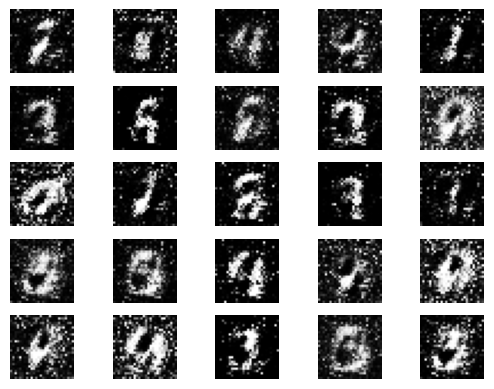

[101/400][0/16] 	Loss_D: 2.2282	Loss_G: 0.6958	D(x): 0.1975	D(G(z)): 0.0357
[102/400][0/16] 	Loss_D: 0.7983	Loss_G: 2.4293	D(x): 0.8343	D(G(z)): 0.4217
[103/400][0/16] 	Loss_D: 0.7925	Loss_G: 3.5816	D(x): 0.8949	D(G(z)): 0.4616
[104/400][0/16] 	Loss_D: 0.7228	Loss_G: 1.4370	D(x): 0.6878	D(G(z)): 0.2290
[105/400][0/16] 	Loss_D: 0.8559	Loss_G: 3.6336	D(x): 0.9128	D(G(z)): 0.5030
[106/400][0/16] 	Loss_D: 0.7534	Loss_G: 2.5849	D(x): 0.8557	D(G(z)): 0.4106
[107/400][0/16] 	Loss_D: 0.7250	Loss_G: 2.2806	D(x): 0.8180	D(G(z)): 0.3639
[108/400][0/16] 	Loss_D: 0.8209	Loss_G: 2.3307	D(x): 0.8306	D(G(z)): 0.4428
[109/400][0/16] 	Loss_D: 0.6175	Loss_G: 1.4137	D(x): 0.7189	D(G(z)): 0.1969
[110/400][0/16] 	Loss_D: 0.9700	Loss_G: 1.2441	D(x): 0.4855	D(G(z)): 0.0560
[111/400][0/16] 	Loss_D: 0.4292	Loss_G: 2.1790	D(x): 0.8008	D(G(z)): 0.1592
[112/400][0/16] 	Loss_D: 0.6290	Loss_G: 1.7677	D(x): 0.7516	D(G(z)): 0.2387
[113/400][0/16] 	Loss_D: 0.7227	Loss_G: 2.8015	D(x): 0.8628	D(G(z)): 0.4109
[114/400][0/

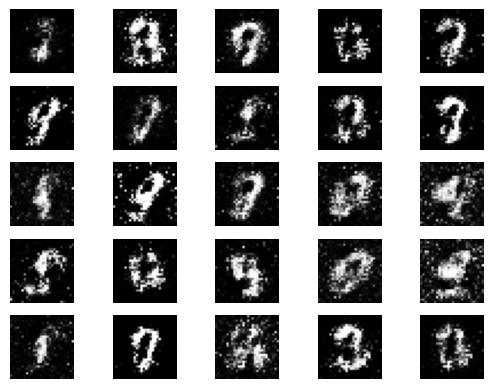

[126/400][0/16] 	Loss_D: 1.2949	Loss_G: 0.6405	D(x): 0.3657	D(G(z)): 0.0366
[127/400][0/16] 	Loss_D: 0.7481	Loss_G: 1.5281	D(x): 0.6931	D(G(z)): 0.2008
[128/400][0/16] 	Loss_D: 0.6925	Loss_G: 1.6172	D(x): 0.6630	D(G(z)): 0.1240
[129/400][0/16] 	Loss_D: 0.6254	Loss_G: 2.4015	D(x): 0.8213	D(G(z)): 0.3112
[130/400][0/16] 	Loss_D: 0.9165	Loss_G: 0.9784	D(x): 0.5547	D(G(z)): 0.1454
[131/400][0/16] 	Loss_D: 0.7679	Loss_G: 2.2838	D(x): 0.9026	D(G(z)): 0.4618
[132/400][0/16] 	Loss_D: 0.9174	Loss_G: 2.2700	D(x): 0.9200	D(G(z)): 0.5250
[133/400][0/16] 	Loss_D: 0.5325	Loss_G: 1.8724	D(x): 0.7768	D(G(z)): 0.2047
[134/400][0/16] 	Loss_D: 0.5657	Loss_G: 1.7187	D(x): 0.8091	D(G(z)): 0.2655
[135/400][0/16] 	Loss_D: 0.6579	Loss_G: 2.9594	D(x): 0.8886	D(G(z)): 0.3795
[136/400][0/16] 	Loss_D: 0.5569	Loss_G: 2.4374	D(x): 0.8347	D(G(z)): 0.2827
[137/400][0/16] 	Loss_D: 0.5681	Loss_G: 2.2888	D(x): 0.8272	D(G(z)): 0.2782
[138/400][0/16] 	Loss_D: 1.3106	Loss_G: 1.1544	D(x): 0.3744	D(G(z)): 0.0327
[139/400][0/

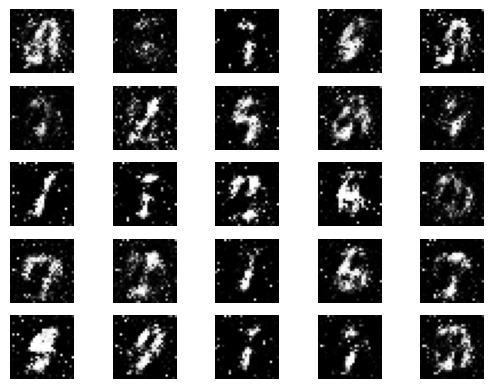

[151/400][0/16] 	Loss_D: 1.0977	Loss_G: 5.1585	D(x): 0.9513	D(G(z)): 0.6133
[152/400][0/16] 	Loss_D: 0.8143	Loss_G: 2.8594	D(x): 0.9277	D(G(z)): 0.4892
[153/400][0/16] 	Loss_D: 0.7677	Loss_G: 4.0824	D(x): 0.9112	D(G(z)): 0.4317
[154/400][0/16] 	Loss_D: 0.4704	Loss_G: 1.8568	D(x): 0.7812	D(G(z)): 0.1529
[155/400][0/16] 	Loss_D: 0.9435	Loss_G: 4.7775	D(x): 0.9500	D(G(z)): 0.5504
[156/400][0/16] 	Loss_D: 0.6658	Loss_G: 1.5429	D(x): 0.6866	D(G(z)): 0.0602
[157/400][0/16] 	Loss_D: 0.4837	Loss_G: 2.2373	D(x): 0.7667	D(G(z)): 0.0954
[158/400][0/16] 	Loss_D: 0.5711	Loss_G: 2.0155	D(x): 0.9328	D(G(z)): 0.3681
[159/400][0/16] 	Loss_D: 0.6018	Loss_G: 3.0758	D(x): 0.8657	D(G(z)): 0.3073
[160/400][0/16] 	Loss_D: 0.6982	Loss_G: 1.3884	D(x): 0.6642	D(G(z)): 0.1183
[161/400][0/16] 	Loss_D: 0.6042	Loss_G: 1.2125	D(x): 0.7258	D(G(z)): 0.1328
[162/400][0/16] 	Loss_D: 0.5590	Loss_G: 2.1212	D(x): 0.7956	D(G(z)): 0.2227
[163/400][0/16] 	Loss_D: 0.6547	Loss_G: 2.0017	D(x): 0.8381	D(G(z)): 0.3460
[164/400][0/

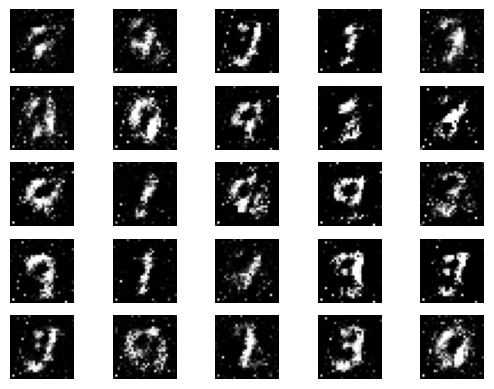

[176/400][0/16] 	Loss_D: 0.7150	Loss_G: 1.5324	D(x): 0.7102	D(G(z)): 0.2250
[177/400][0/16] 	Loss_D: 0.6715	Loss_G: 1.6887	D(x): 0.7269	D(G(z)): 0.2368
[178/400][0/16] 	Loss_D: 0.7982	Loss_G: 3.4093	D(x): 0.9316	D(G(z)): 0.4900
[179/400][0/16] 	Loss_D: 0.6343	Loss_G: 2.9148	D(x): 0.8953	D(G(z)): 0.3671
[180/400][0/16] 	Loss_D: 0.7005	Loss_G: 2.4169	D(x): 0.8436	D(G(z)): 0.3616
[181/400][0/16] 	Loss_D: 1.1539	Loss_G: 4.2235	D(x): 0.9407	D(G(z)): 0.6117
[182/400][0/16] 	Loss_D: 0.9857	Loss_G: 3.5182	D(x): 0.9142	D(G(z)): 0.5418
[183/400][0/16] 	Loss_D: 0.5327	Loss_G: 2.2389	D(x): 0.8536	D(G(z)): 0.2697
[184/400][0/16] 	Loss_D: 0.6675	Loss_G: 2.3511	D(x): 0.8477	D(G(z)): 0.3484
[185/400][0/16] 	Loss_D: 1.1252	Loss_G: 4.1542	D(x): 0.9384	D(G(z)): 0.5801
[186/400][0/16] 	Loss_D: 0.5769	Loss_G: 2.1716	D(x): 0.8277	D(G(z)): 0.2829
[187/400][0/16] 	Loss_D: 0.6488	Loss_G: 1.9485	D(x): 0.7541	D(G(z)): 0.2525
[188/400][0/16] 	Loss_D: 0.6097	Loss_G: 2.8739	D(x): 0.8600	D(G(z)): 0.3357
[189/400][0/

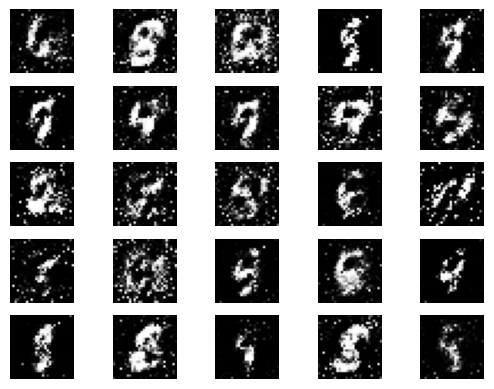

[201/400][0/16] 	Loss_D: 0.5650	Loss_G: 1.8946	D(x): 0.7692	D(G(z)): 0.2057
[202/400][0/16] 	Loss_D: 0.6890	Loss_G: 3.0155	D(x): 0.8969	D(G(z)): 0.3884
[203/400][0/16] 	Loss_D: 1.0113	Loss_G: 1.0560	D(x): 0.5296	D(G(z)): 0.0881
[204/400][0/16] 	Loss_D: 0.8895	Loss_G: 3.7279	D(x): 0.9193	D(G(z)): 0.5018
[205/400][0/16] 	Loss_D: 0.6421	Loss_G: 2.8116	D(x): 0.9099	D(G(z)): 0.3940
[206/400][0/16] 	Loss_D: 0.7065	Loss_G: 2.2479	D(x): 0.7913	D(G(z)): 0.3032
[207/400][0/16] 	Loss_D: 0.5673	Loss_G: 1.6950	D(x): 0.7181	D(G(z)): 0.1118
[208/400][0/16] 	Loss_D: 0.4736	Loss_G: 2.4454	D(x): 0.7712	D(G(z)): 0.1368
[209/400][0/16] 	Loss_D: 0.9586	Loss_G: 3.7032	D(x): 0.9533	D(G(z)): 0.5571
[210/400][0/16] 	Loss_D: 1.0601	Loss_G: 5.0829	D(x): 0.9522	D(G(z)): 0.5898
[211/400][0/16] 	Loss_D: 0.5403	Loss_G: 1.0527	D(x): 0.7492	D(G(z)): 0.1665
[212/400][0/16] 	Loss_D: 0.6930	Loss_G: 3.5866	D(x): 0.9206	D(G(z)): 0.4030
[213/400][0/16] 	Loss_D: 0.7425	Loss_G: 1.4809	D(x): 0.6533	D(G(z)): 0.1127
[214/400][0/

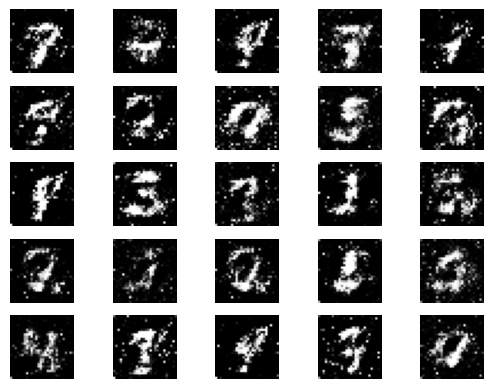

[226/400][0/16] 	Loss_D: 0.4683	Loss_G: 3.2209	D(x): 0.9204	D(G(z)): 0.2876
[227/400][0/16] 	Loss_D: 0.4524	Loss_G: 2.3673	D(x): 0.8349	D(G(z)): 0.1965
[228/400][0/16] 	Loss_D: 1.3047	Loss_G: 0.6427	D(x): 0.4166	D(G(z)): 0.0232
[229/400][0/16] 	Loss_D: 0.8300	Loss_G: 4.3533	D(x): 0.9082	D(G(z)): 0.4738
[230/400][0/16] 	Loss_D: 0.9540	Loss_G: 4.7022	D(x): 0.9424	D(G(z)): 0.5597
[231/400][0/16] 	Loss_D: 1.2914	Loss_G: 5.2471	D(x): 0.9822	D(G(z)): 0.6594
[232/400][0/16] 	Loss_D: 0.6607	Loss_G: 3.3895	D(x): 0.8880	D(G(z)): 0.3671
[233/400][0/16] 	Loss_D: 0.4117	Loss_G: 2.2563	D(x): 0.8103	D(G(z)): 0.1326
[234/400][0/16] 	Loss_D: 0.4388	Loss_G: 1.6992	D(x): 0.7693	D(G(z)): 0.0938
[235/400][0/16] 	Loss_D: 0.3354	Loss_G: 2.1952	D(x): 0.8558	D(G(z)): 0.1233
[236/400][0/16] 	Loss_D: 0.3648	Loss_G: 2.1765	D(x): 0.7859	D(G(z)): 0.0655
[237/400][0/16] 	Loss_D: 0.4395	Loss_G: 3.4533	D(x): 0.9210	D(G(z)): 0.2693
[238/400][0/16] 	Loss_D: 0.3566	Loss_G: 2.7836	D(x): 0.8106	D(G(z)): 0.0915
[239/400][0/

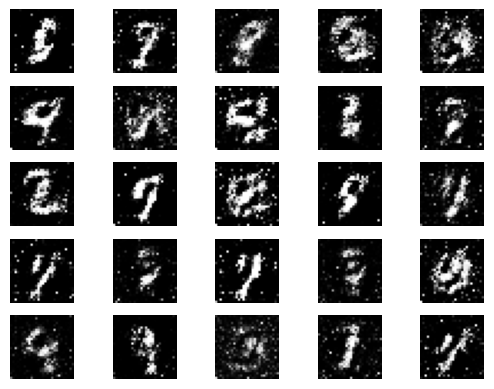

[251/400][0/16] 	Loss_D: 0.3627	Loss_G: 2.4325	D(x): 0.8784	D(G(z)): 0.1790
[252/400][0/16] 	Loss_D: 0.4285	Loss_G: 3.1742	D(x): 0.9043	D(G(z)): 0.2436
[253/400][0/16] 	Loss_D: 0.4142	Loss_G: 3.4105	D(x): 0.9079	D(G(z)): 0.2196
[254/400][0/16] 	Loss_D: 0.4124	Loss_G: 1.5062	D(x): 0.8789	D(G(z)): 0.1998
[255/400][0/16] 	Loss_D: 0.4903	Loss_G: 2.1599	D(x): 0.8164	D(G(z)): 0.2030
[256/400][0/16] 	Loss_D: 0.3422	Loss_G: 2.3723	D(x): 0.8532	D(G(z)): 0.1300
[257/400][0/16] 	Loss_D: 0.3757	Loss_G: 2.9467	D(x): 0.8318	D(G(z)): 0.1198
[258/400][0/16] 	Loss_D: 0.4307	Loss_G: 2.9369	D(x): 0.8827	D(G(z)): 0.2151
[259/400][0/16] 	Loss_D: 0.4447	Loss_G: 2.4312	D(x): 0.8645	D(G(z)): 0.2128
[260/400][0/16] 	Loss_D: 0.4073	Loss_G: 2.1927	D(x): 0.8596	D(G(z)): 0.1808
[261/400][0/16] 	Loss_D: 0.6177	Loss_G: 4.0481	D(x): 0.9485	D(G(z)): 0.3876
[262/400][0/16] 	Loss_D: 0.3637	Loss_G: 2.7295	D(x): 0.8606	D(G(z)): 0.1526
[263/400][0/16] 	Loss_D: 0.5201	Loss_G: 1.8551	D(x): 0.7546	D(G(z)): 0.1011
[264/400][0/

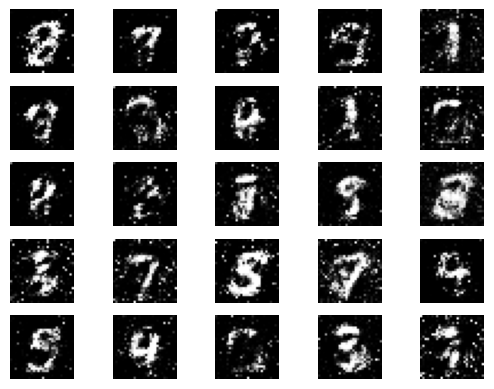

[276/400][0/16] 	Loss_D: 0.4433	Loss_G: 3.4057	D(x): 0.8720	D(G(z)): 0.2211
[277/400][0/16] 	Loss_D: 0.4796	Loss_G: 1.2204	D(x): 0.7273	D(G(z)): 0.0787
[278/400][0/16] 	Loss_D: 0.8440	Loss_G: 1.2141	D(x): 0.5852	D(G(z)): 0.0405
[279/400][0/16] 	Loss_D: 0.7457	Loss_G: 1.2603	D(x): 0.6152	D(G(z)): 0.0280
[280/400][0/16] 	Loss_D: 0.5707	Loss_G: 1.9857	D(x): 0.7288	D(G(z)): 0.1098
[281/400][0/16] 	Loss_D: 0.4970	Loss_G: 2.6048	D(x): 0.8436	D(G(z)): 0.2213
[282/400][0/16] 	Loss_D: 0.4484	Loss_G: 2.9311	D(x): 0.8416	D(G(z)): 0.1803
[283/400][0/16] 	Loss_D: 0.7298	Loss_G: 1.0428	D(x): 0.6468	D(G(z)): 0.0870
[284/400][0/16] 	Loss_D: 0.5792	Loss_G: 2.0743	D(x): 0.8106	D(G(z)): 0.2297
[285/400][0/16] 	Loss_D: 0.5174	Loss_G: 2.3104	D(x): 0.8087	D(G(z)): 0.1950
[286/400][0/16] 	Loss_D: 0.9011	Loss_G: 4.7319	D(x): 0.9418	D(G(z)): 0.5050
[287/400][0/16] 	Loss_D: 0.6156	Loss_G: 2.2587	D(x): 0.7947	D(G(z)): 0.2547
[288/400][0/16] 	Loss_D: 0.5019	Loss_G: 2.1127	D(x): 0.7971	D(G(z)): 0.1659
[289/400][0/

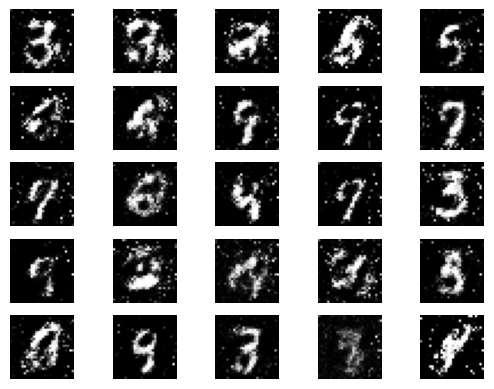

[301/400][0/16] 	Loss_D: 1.7421	Loss_G: 5.8043	D(x): 0.9768	D(G(z)): 0.7425
[302/400][0/16] 	Loss_D: 0.7065	Loss_G: 1.1977	D(x): 0.6323	D(G(z)): 0.0913
[303/400][0/16] 	Loss_D: 0.4746	Loss_G: 1.7572	D(x): 0.7695	D(G(z)): 0.1236
[304/400][0/16] 	Loss_D: 0.5902	Loss_G: 2.7347	D(x): 0.8421	D(G(z)): 0.2971
[305/400][0/16] 	Loss_D: 0.5986	Loss_G: 1.7815	D(x): 0.8055	D(G(z)): 0.2518
[306/400][0/16] 	Loss_D: 1.3799	Loss_G: 0.5884	D(x): 0.4017	D(G(z)): 0.0256
[307/400][0/16] 	Loss_D: 0.5533	Loss_G: 1.1892	D(x): 0.7047	D(G(z)): 0.1334
[308/400][0/16] 	Loss_D: 1.0758	Loss_G: 3.1617	D(x): 0.9288	D(G(z)): 0.5470
[309/400][0/16] 	Loss_D: 1.2030	Loss_G: 0.9795	D(x): 0.4659	D(G(z)): 0.0399
[310/400][0/16] 	Loss_D: 0.5958	Loss_G: 2.1620	D(x): 0.8561	D(G(z)): 0.3050
[311/400][0/16] 	Loss_D: 0.5216	Loss_G: 1.8759	D(x): 0.8156	D(G(z)): 0.2224
[312/400][0/16] 	Loss_D: 0.5397	Loss_G: 1.9998	D(x): 0.7269	D(G(z)): 0.1189
[313/400][0/16] 	Loss_D: 0.5464	Loss_G: 1.9122	D(x): 0.7948	D(G(z)): 0.2111
[314/400][0/

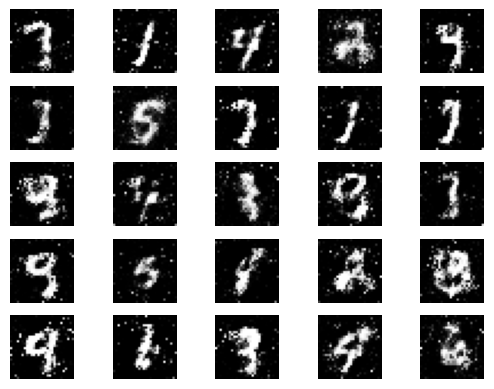

[326/400][0/16] 	Loss_D: 0.5682	Loss_G: 1.9908	D(x): 0.7216	D(G(z)): 0.1282
[327/400][0/16] 	Loss_D: 0.6036	Loss_G: 2.1233	D(x): 0.7105	D(G(z)): 0.1334
[328/400][0/16] 	Loss_D: 0.8090	Loss_G: 0.8938	D(x): 0.5981	D(G(z)): 0.0707
[329/400][0/16] 	Loss_D: 0.8794	Loss_G: 1.4415	D(x): 0.5772	D(G(z)): 0.0863
[330/400][0/16] 	Loss_D: 0.7493	Loss_G: 3.0426	D(x): 0.9421	D(G(z)): 0.4515
[331/400][0/16] 	Loss_D: 0.5103	Loss_G: 1.7851	D(x): 0.8116	D(G(z)): 0.2228
[332/400][0/16] 	Loss_D: 0.4828	Loss_G: 2.3963	D(x): 0.8088	D(G(z)): 0.1873
[333/400][0/16] 	Loss_D: 0.5965	Loss_G: 1.5896	D(x): 0.6793	D(G(z)): 0.1259
[334/400][0/16] 	Loss_D: 0.4703	Loss_G: 1.3268	D(x): 0.7490	D(G(z)): 0.1124
[335/400][0/16] 	Loss_D: 0.5641	Loss_G: 1.5572	D(x): 0.7240	D(G(z)): 0.1480
[336/400][0/16] 	Loss_D: 1.1294	Loss_G: 4.0596	D(x): 0.9664	D(G(z)): 0.6095
[337/400][0/16] 	Loss_D: 1.0398	Loss_G: 3.8814	D(x): 0.9539	D(G(z)): 0.5745
[338/400][0/16] 	Loss_D: 0.6049	Loss_G: 2.0739	D(x): 0.7858	D(G(z)): 0.2221
[339/400][0/

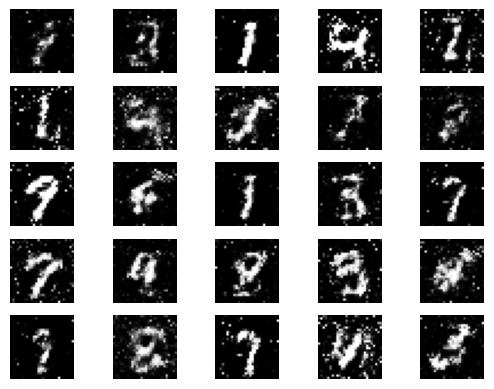

[351/400][0/16] 	Loss_D: 0.6378	Loss_G: 2.4097	D(x): 0.8993	D(G(z)): 0.3507
[352/400][0/16] 	Loss_D: 0.8057	Loss_G: 1.2735	D(x): 0.6440	D(G(z)): 0.1799
[353/400][0/16] 	Loss_D: 0.5070	Loss_G: 1.7701	D(x): 0.7505	D(G(z)): 0.1398
[354/400][0/16] 	Loss_D: 0.6600	Loss_G: 1.3177	D(x): 0.6884	D(G(z)): 0.1598
[355/400][0/16] 	Loss_D: 1.1167	Loss_G: 3.5302	D(x): 0.9235	D(G(z)): 0.5703
[356/400][0/16] 	Loss_D: 0.6788	Loss_G: 2.1481	D(x): 0.7957	D(G(z)): 0.3100
[357/400][0/16] 	Loss_D: 0.6355	Loss_G: 2.4639	D(x): 0.8359	D(G(z)): 0.3140
[358/400][0/16] 	Loss_D: 0.8220	Loss_G: 1.0967	D(x): 0.6160	D(G(z)): 0.1885
[359/400][0/16] 	Loss_D: 0.7509	Loss_G: 3.6234	D(x): 0.9148	D(G(z)): 0.4394
[360/400][0/16] 	Loss_D: 0.6102	Loss_G: 2.1279	D(x): 0.7708	D(G(z)): 0.1849
[361/400][0/16] 	Loss_D: 0.8006	Loss_G: 0.8895	D(x): 0.6148	D(G(z)): 0.1381
[362/400][0/16] 	Loss_D: 0.8581	Loss_G: 0.8291	D(x): 0.5340	D(G(z)): 0.0499
[363/400][0/16] 	Loss_D: 1.0601	Loss_G: 0.6886	D(x): 0.4707	D(G(z)): 0.0530
[364/400][0/

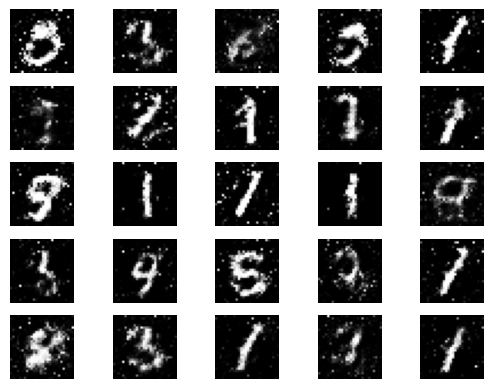

[376/400][0/16] 	Loss_D: 0.6720	Loss_G: 1.6678	D(x): 0.6859	D(G(z)): 0.1292
[377/400][0/16] 	Loss_D: 0.5819	Loss_G: 1.9027	D(x): 0.7805	D(G(z)): 0.2120
[378/400][0/16] 	Loss_D: 0.5391	Loss_G: 1.6870	D(x): 0.7449	D(G(z)): 0.1700
[379/400][0/16] 	Loss_D: 0.7714	Loss_G: 1.9420	D(x): 0.7462	D(G(z)): 0.2652
[380/400][0/16] 	Loss_D: 0.8006	Loss_G: 3.1992	D(x): 0.8944	D(G(z)): 0.4430
[381/400][0/16] 	Loss_D: 0.8926	Loss_G: 2.6104	D(x): 0.9057	D(G(z)): 0.4923
[382/400][0/16] 	Loss_D: 0.6920	Loss_G: 1.2251	D(x): 0.6613	D(G(z)): 0.1625
[383/400][0/16] 	Loss_D: 0.6236	Loss_G: 1.4444	D(x): 0.7276	D(G(z)): 0.1929
[384/400][0/16] 	Loss_D: 0.6493	Loss_G: 2.2434	D(x): 0.8503	D(G(z)): 0.3019
[385/400][0/16] 	Loss_D: 0.9745	Loss_G: 3.5777	D(x): 0.9256	D(G(z)): 0.5031
[386/400][0/16] 	Loss_D: 1.3549	Loss_G: 0.6457	D(x): 0.3918	D(G(z)): 0.0339
[387/400][0/16] 	Loss_D: 0.6737	Loss_G: 1.6552	D(x): 0.6995	D(G(z)): 0.1640
[388/400][0/16] 	Loss_D: 0.7580	Loss_G: 2.6595	D(x): 0.8667	D(G(z)): 0.4187
[389/400][0/

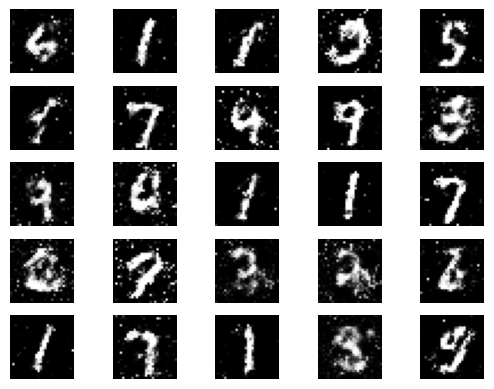

In [10]:

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []

sample_interval=25

print("Starting Training")
# For each epoch
for epoch in range(n_epochs):
  # For each batch in the dataloader
  for i, data in enumerate(mnist_train_loader, 0):
    for iter_inner in range(0,n_iters_inner):
        
      ############################
      ### Train discriminator
      ############################
      ## Train with true data batch
      disc_model.zero_grad()
      # create true data and labels 
      true_imgs = data[0].to(device) # FILL IN HERE
      true_labels = torch.full((true_imgs.size(0),1), 1, device=device).float() # FILL IN HERE 
      # put true data through discriminator
      d_output_true = disc_model.forward(true_imgs) # FILL IN HERE
      # bce loss on true data
      d_loss_true = bce_criterion(d_output_true, true_labels) # FILL IN HERE
      # backpropagation for discriminator, true loss
      d_loss_true.backward()
      disc_true_value = d_output_true.mean().item()

      ## Train with fake data batch
      # create fake data and labels
      # generate batch of random latent vectors
      z_latent_noise = torch.randn((true_imgs.size(0), z_dim), device=device)
      # FILL IN HERE
      # Generate batch of fake images
      fake_imgs = gen_model.forward(z_latent_noise) # FILL IN HERE
      fake_labels = torch.full((true_imgs.size(0),1), 0, device=device).float() # FILL IN HERE
      # put fake data through discriminator
      disc_output_fake = disc_model(fake_imgs.detach()) # FILL IN HERE
      # bce loss on fake data
      disc_loss_fake = bce_criterion(disc_output_fake, fake_labels) 
      # FILL IN HERE
      # backpropagation for discriminator, fake loss
      disc_loss_fake.backward()
      disc_fake_value = disc_output_fake.mean().item()
      # Update discriminator
      optimizer_disc.step()

      d_loss_total = d_loss_true+disc_loss_fake

    ############################
    ### Train generator
    ############################
    gen_model.zero_grad()
    # We have updated the discriminator, so we need to update the output of the discriminator
    disc_gen_output_fake = disc_model(fake_imgs) # FILL IN HERE
    # Generator loss, using the custom loss
    g_loss = loss_fn_gen(disc_gen_output_fake) # FILL IN HERE
    # backpropagation for generator
    g_loss.backward()
    #D_G_z2 = output.mean().item()
    # Update generator
    optimizer_gen.step()

    # Output training stats
    if i % 200 == 0:
      print('[%d/%d][%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
      % (epoch, n_epochs, i, len(mnist_train_loader),d_loss_total.item(), g_loss.item(), disc_true_value, disc_fake_value ))

    # Save Losses for plotting later
    G_losses.append(g_loss.item())
    D_losses.append(d_loss_total.item())

  if(epoch % sample_interval == 0):
    sample_images(gen_model,z_dim, rand_seed=30)

# end samples
sample_images(gen_model,z_dim, rand_seed=30)


## 6/ Navigating in the latent space

One of the main interests in the latent space is to be able to __navigate__ in it. For instance, one operation which is very common is to take two points $z_0$ and $z_1$ and to interpolate between the two. The images resulting from the generation of the interpolated points should ideally be a mix between the two initial points. 

The simplest method of interpolation is simply linear interpolation along the line connecting the two points. Obviously, this supposes that the latent space is linear in some sense, which may not be true, but we are going to take this approach here. 

First, find two inital points $z_0$ and $z_1$ which you feel represent two different digits well, and display their resulting generated images.  

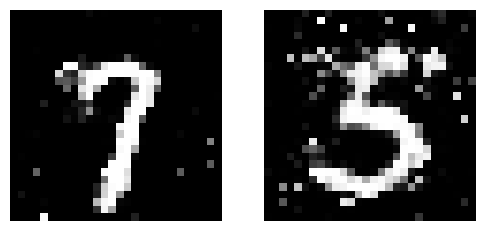

In [11]:
# first image
random_seed = 28 # change this seed to find the best image
torch.manual_seed(random_seed)

z_0 = torch.randn(1, z_dim).to(device) # FILL IN HERE
x_0 = gen_model(z_0) # FILL IN HERE

random_seed = 4 # change this seed to find the best image
torch.manual_seed(random_seed)

z_1 = torch.randn(1, z_dim).to(device) 
x_1 = gen_model(z_1) # FILL IN HERE 

# display images
# FILL IN HERE

def display_images(imgs):
    imgs = imgs.detach().cpu() # Move images to cpu
    imgs = 0.5 * imgs + 0.5 # Un-normalize the images (if you've normalized the images to [-1, 1] range)
    np_imgs = imgs.numpy() # Convert to numpy array

    fig, axes = plt.subplots(1, len(imgs), figsize=(len(imgs)*3,3))
    for i, ax in enumerate(axes):
        ax.imshow(np.squeeze(np_imgs[i]), cmap='gray') # Convert image shape from CxHxW to HxWxC
        ax.axis('off')
        
display_images(torch.stack([x_0, x_1]))

Now, carry out the interpolation between these two points. You should __include__ the starting and ending codes $z_0$ and $z_1$. Display the results.

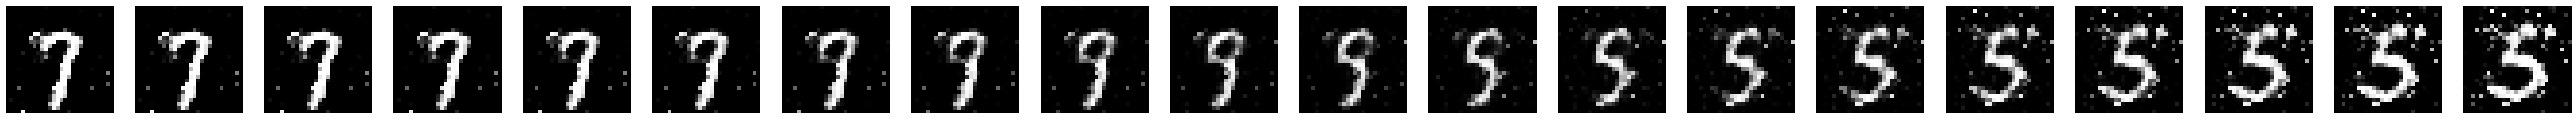

In [12]:
n_interpolation = 20

# FILL IN HERE
# Create a vector of interpolation values
interpolation = torch.linspace(0, 1, steps=n_interpolation, device=device).unsqueeze(1)

# Interpolate in the latent space
z_interpolated = z_0 * (1 - interpolation) + z_1 * interpolation

# Generate images by passing interpolated z to the generator
x_interpolated = gen_model(z_interpolated)

# Display the images
display_images(x_interpolated.detach())

What do you think of the quality of the output images ?


__Answer__

The generated images bear a strong resemblance to the hand-written digits from the MNIST dataset, which suggests that the GAN has successfully learned to create realistic images. Although there are some noticeable artifacts, the quality of the generated images is quite good overall.

Additionally, the transitions in the generated images are smooth and consistent. The seamless shift from the starting image to the ending image shows that similar images correspond to nearby points in the latent space. This characteristic is beneficial because it allows us to generate different variations of an image by slightly altering its point in the latent space. This functionality facilitates techniques such as style transfer.

The path from 7 to 5 in the latent space also passes through 9, showing that these digits share common visual features. This indicates that the model has recognized the similarities between different classes. When a generative model has effectively learned the data representation, a path in the latent space between two classes should intersect other classes. This illustrates that the model has understood the shared characteristics between different classes.

To sum up, these aspects demonstrate the model's proficiency in learning a reliable representation of the data, producing high-quality images, and understanding the inherent structure of the data.

## 7/ Evaluation of navigation

Now, we are going to evaluate this navigation. We will investigate two properties:

- 1/ We are going to see whether by navigating between two points, the model produces images which are categorised in either of the classes (beginning class or end class), or if it traverses a region which is categorised in another class;
- 2/ We are going to see whether the confidence of a classification network in different regions varies much. In other words, when we navigate in the latent space, do we go into zones which do not correspond to any number (according to the classification network) ? 

For this, we will first need a classification network. Take the code from the last lab work on variational autoencoders, and extract the section where we trained a classifier on mnist. Here is the architecture we used:

- conv2d, filter size  3×3 , 32 filters, stride=(2,2), padding="SAME"
- ReLU
- conv2d, filter size  3×3 , 32 filters, stride=(2,2), padding="SAME"
- ReLU
- MaxPool2D, stride=(2,2)
- Flatten
- Dense layer

In [13]:
# define mnist classifier model, loss function, optimiser and the function 'get_accuracy'

# FILL IN HERE
learning_rate = 0.01
n_epochs = 20
batch_size = 64
nb_classes = int(mnist_trainset.targets.max()+1)

# number of convolutional filters to use
nb_filters = 32
# convolution kernel size
kernel_size = (3, 3)
# size of pooling area for max pooling
pool_size = (2, 2)

# --- Size of the successive layers
n_h_0 = 1 #greyscale input images
n_h_1 = nb_filters
n_h_2 = nb_filters

mnist_classification_model = nn.Sequential(
    nn.Conv2d(n_h_0, n_h_1, kernel_size, stride=1, padding="same"),
    nn.ReLU(),
    nn.Conv2d(n_h_1, n_h_2, kernel_size, stride=1, padding="same"),
    nn.ReLU(),
    nn.MaxPool2d(pool_size, stride=(2, 2)),
    nn.Flatten(),
    nn.Linear(14*14*n_h_2, nb_classes)
)

criterion = torch.nn.CrossEntropyLoss() # FILL IN CODE HERE
optimizer = torch.optim.Adam(mnist_classification_model.parameters(), lr=learning_rate)



In [14]:
# training the classifier

# FILL IN HERE
def get_accuracy(x_pred,x_label):
  acc = torch.sum(x_pred == x_label)/(x_pred.shape[0])
  return acc

train_losses=[]
valid_losses=[]

for epoch in range(0,n_epochs):
  train_loss=0.0

  for batch_idx, (imgs, labels) in enumerate(mnist_train_loader):

    # set the gradients back to 0
    optimizer.zero_grad()
    predict=mnist_classification_model(imgs)
    # apply loss function
    loss=criterion(predict,labels)
    acc = get_accuracy(torch.argmax(predict,dim=1),labels)
    # backpropagation
    loss.backward()
    optimizer.step()
    train_loss=loss.item()
  print('Epoch:{} Train Loss:{:.4f} Accuracy:{:.4f}'.format(epoch,train_loss/imgs.shape[0],acc))

Epoch:0 Train Loss:0.0145 Accuracy:0.7750
Epoch:1 Train Loss:0.0074 Accuracy:0.9250
Epoch:2 Train Loss:0.0061 Accuracy:0.8500
Epoch:3 Train Loss:0.0006 Accuracy:1.0000
Epoch:4 Train Loss:0.0002 Accuracy:1.0000
Epoch:5 Train Loss:0.0004 Accuracy:1.0000
Epoch:6 Train Loss:0.0005 Accuracy:1.0000
Epoch:7 Train Loss:0.0011 Accuracy:0.9750
Epoch:8 Train Loss:0.0001 Accuracy:1.0000
Epoch:9 Train Loss:0.0000 Accuracy:1.0000
Epoch:10 Train Loss:0.0000 Accuracy:1.0000
Epoch:11 Train Loss:0.0059 Accuracy:0.9500
Epoch:12 Train Loss:0.0001 Accuracy:1.0000
Epoch:13 Train Loss:0.0003 Accuracy:1.0000
Epoch:14 Train Loss:0.0005 Accuracy:1.0000
Epoch:15 Train Loss:0.0000 Accuracy:1.0000
Epoch:16 Train Loss:0.0002 Accuracy:1.0000
Epoch:17 Train Loss:0.0001 Accuracy:1.0000
Epoch:18 Train Loss:0.0000 Accuracy:1.0000
Epoch:19 Train Loss:0.0000 Accuracy:1.0000


### 7.1/ Evaluation of navigation part 1

Now, create a function which returns the classification returned by this network on mnist images. Remember, the classification model above returns the values __before__ the softmax is applied, and here we want the argmax, rather than the maximum probability. __Note__: the torch.max function returns a tuple: (max_values, max_indices).


In [15]:
def predict_mnist_class(imgs_in,classification_model):
  output_classes = torch.argmax(classification_model(imgs_in),dim=1) 
  # FILL IN HERE
  return(output_classes)

Carry out and print the classification of your interpolated latent space images. What are your remarks ? Does the latent space navigation traverse regions with classes other than those of $z_0$ and $z_1$ ?

In [16]:
z_classes = predict_mnist_class(x_interpolated, mnist_classification_model) # FILL IN HERE
print(z_classes)

tensor([7, 7, 7, 7, 7, 7, 7, 7, 9, 9, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5])


__Answer__

Yes, the latent space navigation traverses regions with classes other than those of $z_0$ and $z_1$. The sequence begins with 7 (which we assume to be the class of $z_0$), transitions through class 9, and ends with 5 (presumed to be the class of $z_1$). This indicates that in the trajectory from 7 to 5 in the latent space, the model has moved through the region associated with the digit 9. 

It is possible to observe that the transition from 7 to 5 is not abrupt. The model first interprets the generated images as digit 9 before settling on digit 5. This suggests that the latent space representations for 7, 9, and 5 have shared features or are close to each other, which makes sense visually as these digits have similar topological features.

In addition, the generator is creating images of sufficient quality that the classifier can indentify them as distinct digits. This reflects positively on the quality of the images produced by the GAN's generator.

### 7.2/ Evaluation of navigation part 2

Even though the network may predict coherent image classes during the navigation, it may predict these classes with different confidences. Ideally, we would like the latent space to contain codes which produce images of constant quality. Therefore, as mentioned above, we want to check these prediction confidences during navigation on our GAN.

Carry this out now. First of all, define a function which, instead of funding the output *classes* of the interpolations, find the *probability* of the most likely class (the same operation as in the lab on variational autoencoders).


In [17]:
def predict_mnist_confidence(imgs_in,classification_model):
  output_classes = torch.max(F.softmax(classification_model(imgs_in),dim=1), dim=1) # FILL IN HERE
  return(output_classes)

Using this function, carry out the second evaluation on the images generated by interpolated latent codes.

In [18]:
z_confidence = predict_mnist_confidence(x_interpolated, mnist_classification_model) #FILL IN HERE
print(z_confidence)

torch.return_types.max(
values=tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 0.9900, 0.7623,
        0.9993, 0.9759, 0.8829, 0.9912, 0.9982, 0.9999, 1.0000, 1.0000, 0.9999,
        0.9982, 0.9771], grad_fn=<MaxBackward0>),
indices=tensor([7, 7, 7, 7, 7, 7, 7, 7, 9, 9, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5]))


Does the confidence change greatly during interpolation ? Does the navigation go through zones where the classification is not confident ? Why do you think this is ? (think about the form/shape of the latent space).

__Answer__

The confidence does not change significantly for most of the interpolation, as the majority of the confidence scores are very close to 1. However, there is a notable drop in confidence around the middle of the interpolation (0.7623). This drop suggests that the model is less certain about the class of the generated images in this region. For instance, the navigation goes through a zone where the classification is less confident, as indicated by the lower confidence value (0.7623). 

This could occur due to the structure of the latent space. The space learned by the GAN organizes similar images near each other. However, the space between distinctly different classes (like 7 and 5 in this case) may not be densely populated with meaningful or representative images, leading to ambiguity. In such regions, the GAN might produce less clear images, which correspondingly reduces the classifier's confidence. Therefore, the model may generate less distinct images while transitioning between different classes.

# __Optional__ : Training on CIFAR

If you want to try another, more challenging database, use the above code and modify it to carry out the GAN training on the CIFAR10 database. Note, it can take a long time to get good results

First, we download the data.

In [19]:
# convert input to Pytorch tensors
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])

# extract mnist data
cifar_trainset = datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
print(cifar_trainset)

#create data loader with smaller dataset size
max_cifar_size = 2000
cifar_trainset_reduced = torch.utils.data.random_split(cifar_trainset, [max_cifar_size, len(cifar_trainset)-max_cifar_size])[0] 
cifar_train_loader = torch.utils.data.DataLoader(cifar_trainset_reduced, batch_size=64, shuffle=True)

# download test dataset
cifar_testset = datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
cifar_test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=64, shuffle=True)

n_rows = 32
n_cols = 32
n_channels = 3
n_pixels = n_rows*n_cols

img_shape = (n_rows, n_cols, n_channels)

Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Files already downloaded and verified


Now, we can redefine the hyper-parameters of the model (change if you wish)

In [20]:
## GAN parameters
z_dim = 10
batch_size = 64
n_epochs = 300
## parameters for training
n_iters_inner=1	#number of internal loops
# Learning rate for optimizers
lr = 0.0002
beta_1 = 0.5

For this case of CIFAR, implement the following architecture :

- Generator :
  - Dense layer to size 1024
  - Leaky ReLU ($\alpha=0.2$)
  - Reshape, to size $4 \times 4 \times64$
  - % size = $4\times4\times64$
  - Conv2d, n_channels=16,kernel size=(3,3), strides=(1,1),padding=(1,1)
  - Upsample(scale_factor=(2,2))
  - %size = $8\times 8\times 16$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2d, n_channels=16,kernel size=(3,3), strides=(1,1),padding=(1,1)
  - Upsample(scale_factor=(2,2))
  - %size=$16 \times 16 \times 16$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2d, n_channels=3,kernel size=(3,3), strides=(1,1),padding=(1,1)
  - Upsample(scale_factor=(2,2))
  - %size = $32 \times 32 \times 3$
  - Tanh activation ( you can use ```Activation('tanh')```)

- Discriminator :
  - % input size : $32 \times 32 \times 3$
  - Conv2D, 32 filters, kernel size = (3,3), strides = (1,1),padding = same
  - % size $32 \times 32 \times 32$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, 32 filters, kernel size = (3,3), strides = (2,2),padding = same
  - %size : $16 \times 16 \times 32$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, 64 filters, kernel size = (3,3), strides = (2,2),padding = same
  - % size : $8 \times 8 \times 64$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, 32 filters, kernel size = (3,3), strides = (2,2),padding = same
  - % size : $4 \times 4 \times 32$
  - Leaky ReLU ($\alpha=0.2$)
  - Flatten
  - Dense layer to size 1
  - Sigmoid activation

  Implement this architecture below, and train the GAN. 

In [21]:
# GAN implementation

# FILL IN HERE

Now, carry out the training (use code above)

In [22]:
# training code

# FILL IN HERE